<a href="https://colab.research.google.com/github/itssraj/agentic-ai/blob/main/LangChain_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain End-to-End: Prompt → Chain → RAG → Agent → UI

In this notebook, we will build a small, reliable LLM application step by step:


1. **Hello LLM** (baseline)  
2. **Prompting + LCEL + Output Parser**  
3. **RAG (build once, re-use)** with sources  
4. **Agent + Tools** (retriever tool + optional web search)  
5. **Tiny UI** (Gradio)  
6. **Custom Tool (@tool) example**  

**Goal**: See how orchestration with LangChain implements grounding, structure, and simple tool-use so you can ship dependable features.

## 0) Install & Configure (run once)

- Installs pinned versions to reduce API drift.  
- Prompts for your keys as needed.  
- **Optional**: If you have a LangSmith key, tracing will be enabled automatically.

> If you re-run the notebook later, you can skip re-installation if your environment already has these packages.

In [ ]:

# If you're in a managed environment, these may already be installed.
# Comment out lines you don't need.
%pip install -qU "langchain>=0.2" "langchain-core>=0.2" "langchain-community>=0.2" \
               "langchain-openai>=0.1" langchainhub faiss-cpu langchain-text-splitters \
               tavily-python gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 8

In [ ]:

import os, getpass, warnings, sys

warnings.filterwarnings("ignore")

def ensure_env(key: str, prompt: str):
    if not os.getenv(key):
        try:
            val = getpass.getpass(prompt)
        except Exception:
            # Fallback for environments without stdin (e.g. some hosted notebooks)
            val = ""
        if val:
            os.environ[key] = val

# --- Required for LLM & embeddings ---
ensure_env("OPENAI_API_KEY", "Enter your OpenAI API Key (skipped if already set): ")

# --- Optional: LangSmith tracing ---
# If you have LANGCHAIN_API_KEY set, we turn on tracing v2 automatically.
if os.getenv("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    print("LangSmith tracing enabled (TRACING_V2=true).")
else:
    os.environ.pop("LANGCHAIN_TRACING_V2", None)
    print("LangSmith tracing not enabled (no LANGCHAIN_API_KEY). Proceeding without tracing.")

# --- Optional: Tavily web search ---
# If not set, we'll skip adding the Tavily tool; everything else runs fine.
if not os.getenv("TAVILY_API_KEY"):
    print("No TAVILY_API_KEY found. Agent will run without web search tool (retriever-only).")
else:
    print("Tavily web search tool will be available.")


Enter your OpenAI API Key (skipped if already set): ··········
LangSmith tracing not enabled (no LANGCHAIN_API_KEY). Proceeding without tracing.
No TAVILY_API_KEY found. Agent will run without web search tool (retriever-only).


## 1) Hello LLM (baseline)

A single LLM call; no structure, no grounding.  
We'll improve over this baseline throughout the notebook.

In [ ]:

from langchain_openai import ChatOpenAI

# A deterministic model (temperature=0) for reproducible outputs.
llm = ChatOpenAI(temperature=0)

baseline_q = "In one sentence, how can LangSmith help with testing LLM apps?"
baseline_a = llm.invoke(baseline_q)
print("Q:", baseline_q)
print("\nBaseline (no context):\n", baseline_a.content)


Q: In one sentence, how can LangSmith help with testing LLM apps?

Baseline (no context):
 LangSmith can provide comprehensive testing services for LLM apps to ensure they meet quality standards and perform optimally.


## 2) Prompting + LCEL + Output Parsing

Use **LCEL** (`|`) to pipe **PromptTemplate → LLM → OutputParser** so your code is composable and testable.

In [ ]:

from langchain_classic.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a concise technical assistant."),
    ("human", "Rewrite the following answer as 3 crisp bullet points:\n\n{answer}")
])

parser = StrOutputParser()

chain = prompt | llm | parser

rephrased = chain.invoke({"answer": baseline_a.content})
print(rephrased)


- LangSmith offers comprehensive testing services for LLM apps
- Ensures apps meet quality standards
- Ensures optimal performance


## 3) RAG

We’ll load a small corpus (LangSmith docs), split it, embed it, index it with **FAISS**, and wire a **Retrieval Chain**.

- This section runs **once** and is reused later by the Agent.
- If web loading fails, we fall back to a tiny local sample so the demo still runs.
- We'll also **surface sources** so you can see why answers improved.

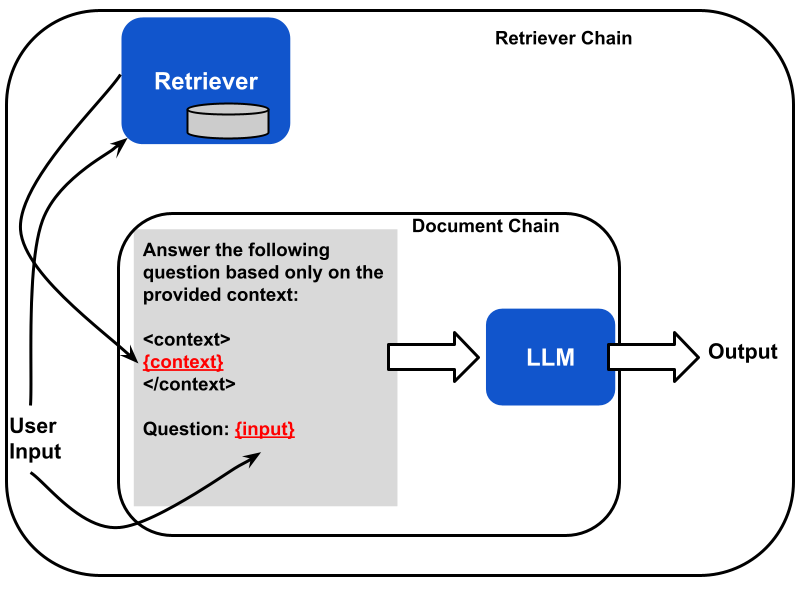

In [ ]:

from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_classic.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains import create_retrieval_chain
from langchain_classic.prompts import ChatPromptTemplate
from langchain_classic.schema import Document

def build_docs() -> List[Document]:
    urls = [
        "https://docs.smith.langchain.com/overview",
        "https://docs.smith.langchain.com/user_guide",
        "https://docs.smith.langchain.com/evaluation",
    ]
    try:
        loader = WebBaseLoader(urls)
        docs = loader.load()
        if not docs:
            raise ValueError("Web loader returned no docs.")
        print(f"Loaded {len(docs)} documents from the web.")
        return docs
    except Exception as e:
        print("Web load failed, using fallback docs. Reason:", e)
        text = (
            "LangSmith is a platform for observing, evaluating, and debugging LLM applications. "
            "It provides tracing, dataset management, evaluations, and experiment tracking to help teams ship reliable LLM features."
        )
        return [
            Document(page_content=text, metadata={"source": "local_fallback", "title": "LangSmith Overview (Local)"})
        ]

raw_docs = build_docs()

splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=150)
chunks = splitter.split_documents(raw_docs)
print(f"Split into {len(chunks)} chunks.")

embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

rag_prompt = ChatPromptTemplate.from_template(
    "You are a precise assistant. Use the provided context to answer the question.\n"
    "If the answer is not in the context, say you don't know.\n\n"
    "Question: {input}\n\n"
    "Context:\n{context}\n\n"
    "Answer in 3 concise bullet points and include citations when possible."
)

document_chain = create_stuff_documents_chain(llm, rag_prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

q = "Name two LangSmith features that help with testing, and explain briefly how to use them."
result = retrieval_chain.invoke({"input": q})

print("Q:", q)
print("\nRAG Answer:\n", result["answer"])

# Show top sources explicitly
print("\nTop sources:")
for d in retriever.invoke(q)[:4]:
    print("-", d.metadata.get("source", ""), d.metadata.get("title", ""))


Loaded 3 documents from the web.
Split into 55 chunks.
Q: Name two LangSmith features that help with testing, and explain briefly how to use them.

RAG Answer:
 - Track test results in LangSmith: Easily view all experiments associated with a dataset, share results, compare systems, and debug failing tests.
- Write evaluations as tests: Useful for custom logic, heterogenous evaluations, and asserting basic things about system outputs.
- Use testing tools for evaluating system outputs and asserting basic properties.

Top sources:
- https://docs.smith.langchain.com/evaluation Evaluation Concepts - Docs by LangChain
- https://docs.smith.langchain.com/evaluation Evaluation Concepts - Docs by LangChain
- https://docs.smith.langchain.com/evaluation Evaluation Concepts - Docs by LangChain
- https://docs.smith.langchain.com/overview LangSmith docs - Docs by LangChain


## 4) Agent + Tools (on top of the same RAG)

We turn our retriever into a **Tool** and create an **OpenAI Functions Agent**.  
Optionally, if a **Tavily** API key is present, we add a web search tool.

> **Why an Agent?** It can decide *when* to use retrieval vs. answer directly, and sequence multi-step reasoning.

In [ ]:

from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    name="langsmith_search",
    description=(
        "Use this to look up information about LangSmith features, evaluation, "
        "tracing, datasets, and user guide details."
    ),
)
tools = [retriever_tool]

# Optional Tavily tool
search_tool = None
try:
    if os.getenv("TAVILY_API_KEY"):
        from langchain_community.tools.tavily_search import TavilySearchResults
        search_tool = TavilySearchResults(max_results=5)
        tools.append(search_tool)
        print("Tavily search tool added.")
    else:
        print("Proceeding without Tavily; retriever-only agent.")
except Exception as e:
    print("Skipping Tavily tool due to import/runtime issue:", e)

# Create agent (support both older/newer APIs)
from langchain_classic import hub
from langchain_openai import ChatOpenAI
from langchain_classic.agents import AgentExecutor

llm_agent = ChatOpenAI(temperature=0)
agent_prompt = hub.pull("hwchase17/openai-functions-agent")

# Backward-compatible import: create_openai_functions_agent (new) or create_tool_calling_agent (fallback)
try:
    from langchain_classic.agents import create_openai_functions_agent as _create_agent
except Exception:
    from langchain_classic.agents import create_tool_calling_agent as _create_agent

agent = _create_agent(llm_agent, tools, agent_prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

print("Agent ready. Tools:", [t.name for t in tools])


Proceeding without Tavily; retriever-only agent.
Agent ready. Tools: ['langsmith_search']


In [ ]:

# Try queries that benefit from retrieval; avoid unrelated domains like live weather.
queries = [
    "List two LangSmith capabilities that support evaluation and how to use them.",
    "Where do the docs explain tracing? Summarize in 3 bullets.",
]

for q in queries:
    print("\n==========================")
    print("AGENT Q:", q)
    out = agent_executor.invoke({"input": q})
    print("\nAGENT A:\n", out.get("output", out))



AGENT Q: List two LangSmith capabilities that support evaluation and how to use them.


> Entering new AgentExecutor chain...

Invoking: `langsmith_search` with `{'query': 'evaluation capabilities'}`


curated examplesHistorical tracesSynthetic dataSplitsVersionsEvaluatorsEvaluator inputsEvaluator outputsDefining evaluatorsEvaluation techniquesHumanHeuristicLLM-as-judgePairwiseExperimentExperiment configurationRepetitionsConcurrencyevaluateaevaluateCachingAnnotation queuesOffline evaluationBenchmarkingUnit testsRegression testsBacktestingPairwise evaluationOnline evaluationTestingEvaluations vs testingUsing pytest and Vitest/JestEvaluation ConceptsCopy pageCopy pageLangSmith makes building high-quality evaluations easy. This guide explains the key concepts of the LangSmith evaluation framework. The building blocks of the LangSmith framework are:

​Pairwise evaluation
For some tasks it is easier for a human or LLM grader to determine if “version A is better than B” than to assign an ab

## 5) Gradio: Quickly Build & Share ML Apps ... or to be more accurate PoCs

A minimal chat interface that routes user messages to the agent.  
If Tavily is not available, the agent still works with the retriever tool.

In [ ]:

import gradio as gr

def chat_fn(message, history):
    # We pass only the latest message to the agent; AgentExecutor handles internal state.
    try:
        out = agent_executor.invoke({"input": message})
        return out.get("output", "")
    except Exception as e:
        return f"Error: {e}"

with gr.Blocks() as demo:
    gr.Markdown("# LangChain Agent Chat")
    gr.Markdown("Ask about LangSmith docs and features. (Web search tool available only if TAVILY_API_KEY set.)")
    chat = gr.ChatInterface(chat_fn)
    gr.Markdown("Tip: Try questions like *'Where is tracing documented?'* or *'How do evaluations work?*'")

# Uncomment the next line to launch locally inside a notebook:
# demo.launch(share=False)
print("Gradio app object created. Call demo.launch() to run the UI if you're in an interactive environment.")


Gradio app object created. Call demo.launch() to run the UI if you're in an interactive environment.


## 6) Custom Tool (@tool) example

One simple tool is enough to demonstrate schema and descriptions.  
The agent can call this tool if it detects a matching need.

In [ ]:

# Backward-compatible imports for the @tool decorator and renderer
try:
    from langchain_core.tools import tool
except Exception:
    from langchain.tools import tool  # older fallback
from langchain_classic.tools.render import render_text_description

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers a and b."""
    return a * b

# Extend tools for a new agent instance (to avoid mutating previous list unpredictably)
tools2 = tools + [multiply]
print("Tools now include:", [t.name for t in tools2])

# Rebuild the agent with the additional tool
try:
    agent2 = _create_agent(llm_agent, tools2, agent_prompt)
    agent2_exec = AgentExecutor(agent=agent2, tools=tools2, verbose=True)
    print("Agent with custom tool is ready.")
except Exception as e:
    print("Failed to rebuild agent with custom tool:", e)

# Small demo
try:
    out = agent2_exec.invoke({"input": "Multiply 3.5 by 4 and then tell me one LangSmith evaluation feature."})
    print("\nAgent with tool output:\n", out.get("output", out))
except Exception as e:
    print("Tool-call demo error:", e)


Tools now include: ['langsmith_search', 'multiply']
Agent with custom tool is ready.


> Entering new AgentExecutor chain...

Invoking: `multiply` with `{'a': 3.5, 'b': 4}`


14.0
Invoking: `langsmith_search` with `{'query': 'evaluation feature'}`


curated examplesHistorical tracesSynthetic dataSplitsVersionsEvaluatorsEvaluator inputsEvaluator outputsDefining evaluatorsEvaluation techniquesHumanHeuristicLLM-as-judgePairwiseExperimentExperiment configurationRepetitionsConcurrencyevaluateaevaluateCachingAnnotation queuesOffline evaluationBenchmarkingUnit testsRegression testsBacktestingPairwise evaluationOnline evaluationTestingEvaluations vs testingUsing pytest and Vitest/JestEvaluation ConceptsCopy pageCopy pageLangSmith makes building high-quality evaluations easy. This guide explains the key concepts of the LangSmith evaluation framework. The building blocks of the LangSmith framework are:

Evaluation Concepts - Docs by LangChainSkip to main contentWe've raised a $125M Series B to b

## 7) Wrap-up & Next steps

You built an end-to-end app:
- Baseline LLM → **Prompted chain** → **RAG** → **Agent with tools** → **(Optional) UI**
- Re-used the **same retriever** everywhere (built once).
- Optionally enabled **LangSmith** tracing for observability.

**Ideas to extend:**
- Swap FAISS for your vector DB of choice.  
- Add **validators** (output schemas) and **evaluation** suites.  
- Add domain-specific tools (databases, calculators, internal APIs).

> If you want to run the chat UI: uncomment `demo.launch()` in Section 5.